# 0. Install Dependencies and Bring in Data

In [18]:
import pandas as pd
import numpy as np
!pip install tensorflow keras
import keras
import re
import nltk
import tensorflow as tf
import os
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("train.csv")

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [8]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8

In [9]:
from tensorflow.keras.layers import TextVectorization

In [12]:
X = df['comment_text']
y = df[df.columns[2]].values


In [13]:
MAX_FEATURES = 200000 # number of words in the vocab

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [15]:
vectorizer.adapt(X.values)
X.values

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [16]:
vectorized_text = vectorizer(X.values)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [22]:
model = Sequential()

model.add(Embedding(MAX_FEATURES+1, 32))

model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(6, activation='sigmoid'))

In [23]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [25]:
history = model.fit(train, epochs=2, validation_data=val)



Epoch 1/2
6981/6981 [==============================] - 2457s 352ms/step - loss: 0.0626 - val_loss: 0.0508
Epoch 2/2
6981/6981 [==============================] - 2428s 348ms/step - loss: 0.0443 - val_loss: 0.0463


In [26]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

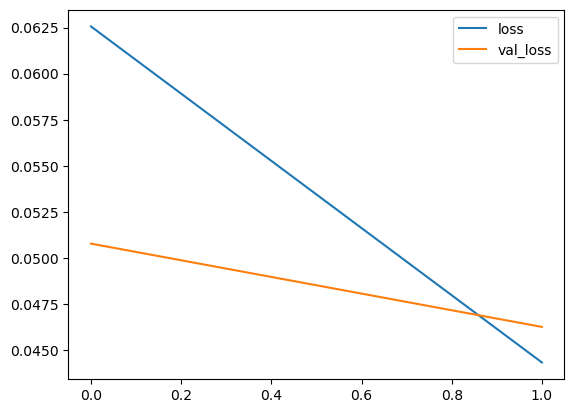

In [27]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [38]:
input_text = vectorizer('I will kill you!')
input_text = tf.expand_dims(input_text, axis=0)


In [39]:
res = model.predict(input_text)

1/1 [==============================] - 0s 44ms/step


In [40]:
(res > 0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [41]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [42]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 55ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [43]:
res.shape

(1, 6)

# 4. Evaluate Model

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [45]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [46]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 56ms/step


In [37]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7989417910575867, Recall:0.6912732720375061, Accuracy:0.6804413318634033
